# Cache size

In [42]:
abs_path = "/home/cc/clio/libCacheSim/scripts/result"

# glob through all of folders in the dir
import os
import glob
import re
import pandas as pd

cache_sizes = [0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.4]


for idx, file in enumerate(glob.glob(abs_path + "/*/result/*.zst")):
    # read file
    file_content = open(file, "r").read()
    # List to store the parsed rows
    data = []

    # Iterate through each line and parse
    idx = 0
    for line in file_content.split('\n'):
        # Use regular expression to extract relevant details
        # match = re.match(r'(.+)\s+(\w+)\s+cache size\s+(\d+\w+),\s+(\d+)\s+req, miss ratio\s+([\d.]+), byte miss ratio\s+([\d.]+)', line)
        match = re.match(r'(.+)\s+([\w\d.-]+)\s+cache size\s+(\d+\w+),\s+(\d+)\s+req, miss ratio\s+([\d.]+), byte miss ratio\s+([\d.]+)', line)
        if match:
            # Extract groups from regex
            file_name, cache_type, cache_size, req_count, miss_ratio, byte_miss_ratio = match.groups()
            cache_size = cache_sizes[idx% len(cache_sizes)]
            idx += 1
            # Append to data list as a tuple
            data.append((file_name.strip(), cache_type, cache_size, int(req_count), float(miss_ratio), float(byte_miss_ratio), float(cache_size)))

    # Create a DataFrame
    df = pd.DataFrame(data, columns=['File name', 'Cache type', 'Cache size', 'Request count', 'Miss ratio', 'Byte miss ratio', 'cache_size'])
    # Save the DataFrame to a CSV file,
    # path is the same folder as file, but with .csv
    df.to_csv(file + ".csv", index=True)


/tmp/ipykernel_4049019/1129700031.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  barplot = sns.barplot(


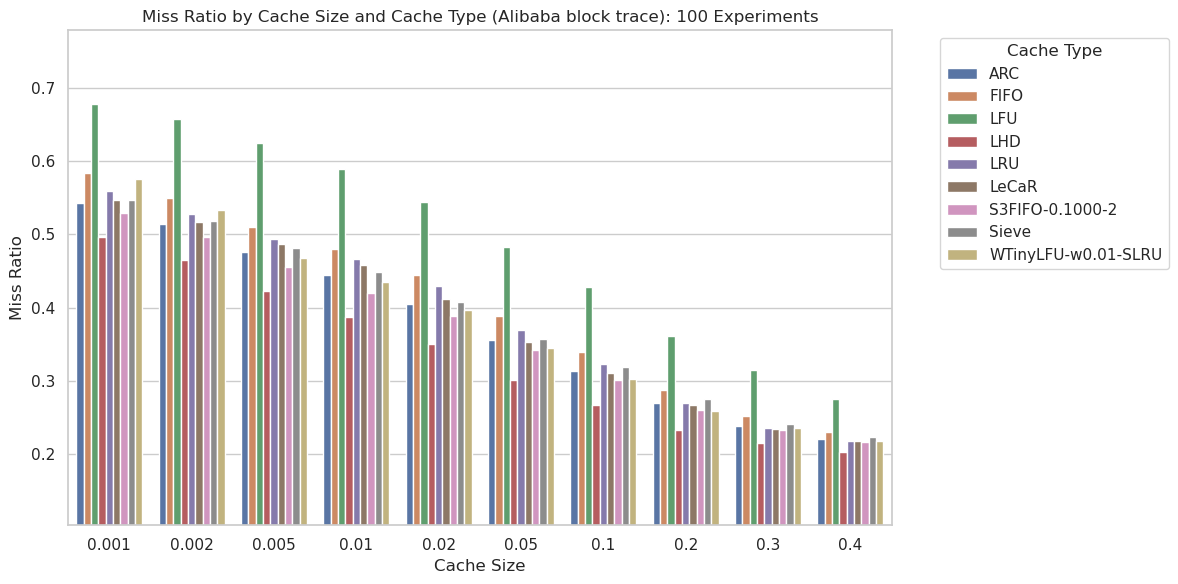

In [53]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import numpy as np

giant_df = pd.DataFrame()
max_idx = 0
for idx, file in enumerate(glob.glob(abs_path + "/*/result/*.csv")):
    df = pd.read_csv(file)
    giant_df = pd.concat([giant_df, df])
    max_idx = max(max_idx, idx)

# Convert 'Cache size' to a numeric type if it's not already
giant_df['Cache size'] = pd.to_numeric(giant_df['Cache size'], errors='coerce')

# Group the data by 'Cache type' and 'Cache size' to calculate the mean and standard deviation of the 'Miss ratio'
grouped_df = giant_df.groupby(['Cache type', 'Cache size']).agg(
    miss_ratio_mean=('Miss ratio', 'mean'),
    miss_ratio_std=('Miss ratio', 'std')
).reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Create a barplot
barplot = sns.barplot(
    x='Cache size',
    y='miss_ratio_mean',
    hue='Cache type',
    data=grouped_df,
    ci=None,
    # palette='viridis'
)

# Get the number of unique cache types and cache sizes
unique_cache_types = grouped_df['Cache type'].nunique()
unique_cache_sizes = grouped_df['Cache size'].nunique()



# Set labels and title
plt.xlabel('Cache Size')
plt.ylabel('Miss Ratio')
plt.title(f'Miss Ratio by Cache Size and Cache Type (Alibaba block trace): {max_idx} Experiments')
plt.legend(title='Cache Type', bbox_to_anchor=(1.05, 1), loc='upper left')

# Set the Y axis to start at minimum
min_val = grouped_df['miss_ratio_mean'].min()
max_val = grouped_df['miss_ratio_mean'].max()
#y lower limit set minval
plt.ylim(min_val-0.1, max_val+0.1)
# Show the plot
plt.tight_layout()
plt.show()


    Cache Size            Algorithm  Score
0        0.001                  LHD    232
1        0.001      S3FIFO-0.1000-2    135
2        0.001  WTinyLFU-w0.01-SLRU     97
3        0.001                  ARC     49
4        0.001                Sieve     46
..         ...                  ...    ...
79       0.400                  ARC     46
80       0.400                  LFU     43
81       0.400      S3FIFO-0.1000-2     36
82       0.400                Sieve     34
83       0.400                 FIFO      2

[84 rows x 3 columns]


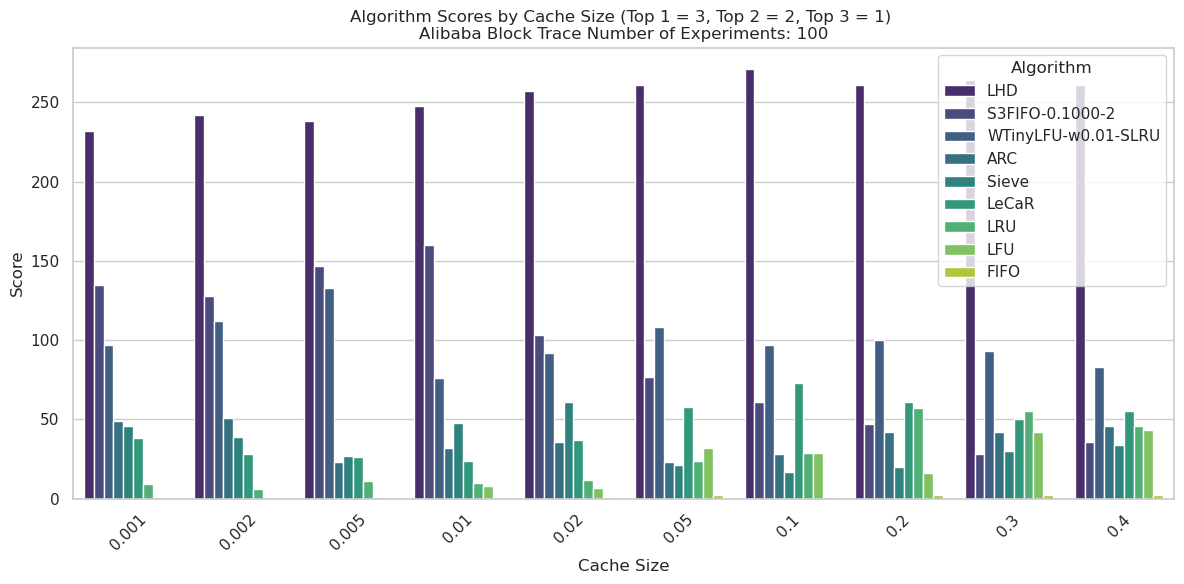

In [55]:
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt

# Dictionary to keep track of the cumulative points per algorithm for each cache size
cache_size_scores = {}

# Process each CSV file separately
for idx, file in enumerate(glob.glob(abs_path + "/*/result/*.csv")):
    df = pd.read_csv(file)
    
    # Convert 'Cache size' to a numeric type if it's not already
    df['Cache size'] = pd.to_numeric(df['Cache size'], errors='coerce')

    # Group by 'Cache size'
    for cache_size, group in df.groupby('Cache size'):
        # Sort by 'Miss ratio' in ascending order to get the best-performing algorithms (lowest miss ratio)
        top_3_algorithms = group.sort_values('Miss ratio').head(3).reset_index(drop=True)

        # Initialize the score dictionary for the cache size if not already done
        if cache_size not in cache_size_scores:
            cache_size_scores[cache_size] = {}

        # Assign points to the top 3 algorithms
        for rank, row in top_3_algorithms.iterrows():
            algorithm = row['Cache type']
            points = 3 - rank  # 1st place gets 3 points, 2nd place gets 2, 3rd place gets 1

            # Update the total score for the algorithm in the current cache size
            if algorithm in cache_size_scores[cache_size]:
                cache_size_scores[cache_size][algorithm] += points
            else:
                cache_size_scores[cache_size][algorithm] = points

# Convert the scores dictionary to a DataFrame for easier analysis
results = []
for cache_size, scores in cache_size_scores.items():
    for algorithm, score in scores.items():
        results.append({'Cache Size': cache_size, 'Algorithm': algorithm, 'Score': score})

scores_df = pd.DataFrame(results)

# Sort the DataFrame by 'Cache Size' and 'Score' in descending order to see the best algorithms for each cache size
scores_df = scores_df.sort_values(by=['Cache Size', 'Score'], ascending=[True, False]).reset_index(drop=True)

# Display the final rankings of algorithms based on the accumulated points, grouped by cache size
print(scores_df)

# Plotting the scores based on cache sizes
plt.figure(figsize=(12, 6))
sns.barplot(data=scores_df, x='Cache Size', y='Score', hue='Algorithm', palette='viridis')

plt.title(f'Algorithm Scores by Cache Size (Top 1 = 3, Top 2 = 2, Top 3 = 1) \nAlibaba Block Trace Number of Experiments: {max_idx}')
plt.xlabel('Cache Size')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Algorithm')
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()


# Cache by time

In [5]:
abs_path = "/home/cc/clio/libCacheSim/scripts/result_"

# glob through all of folders in the dir
import os
import glob
import re
import pandas as pd

for idx, file in enumerate(glob.glob(abs_path + "/*/*.cachesim")):
    # read file
    file_content = open(file, "r").read()
    # List to store the parsed rows
    data = []

    # Iterate through each line and parse
    idx = 0
    for line in file_content.split('\n'):
        # Use regular expression to extract relevant details
        # match = re.match(r'(.+)\s+(\w+)\s+cache size\s+(\d+\w+),\s+(\d+)\s+req, miss ratio\s+([\d.]+), byte miss ratio\s+([\d.]+)', line)
        match = re.match(r'(.+)\s+([\w\d.-]+)\s+cache size\s+(\d+\w+),\s+(\d+)\s+req, miss ratio\s+([\d.]+), throughput\s+([\d.]+)\s+MQPS\s+(\d+)\s+Retrain-Interval', line)
        if match:
            # Extract groups from regex
            file_name, cache_type, cache_size, req_count, miss_ratio, throughput, retrain_interval= match.groups()
            # Append to data list as a tuple
            data.append((file_name.strip(), cache_type, cache_size, int(req_count), float(miss_ratio), float(throughput), float(retrain_interval)))
    # # Create a DataFrame
    df = pd.DataFrame(data, columns=['File name', 'Cache type', 'Cache size', 'Request count', 'Miss ratio', 'Throughput', 'Retrain Interval'])
    print(df)
    # # Save the DataFrame to a CSV file,
    # # path is the same folder as file, but with .csv
    df.to_csv(file + ".csv", index=True)

                                           File name Cache type Cache size  \
0  /home/cc/clio/libCacheSim/data/alibaba/ftp.pdl...    GLCache     952MiB   
1  /home/cc/clio/libCacheSim/data/alibaba/ftp.pdl...    GLCache     952MiB   
2  /home/cc/clio/libCacheSim/data/alibaba/ftp.pdl...    GLCache     952MiB   

   Request count  Miss ratio  Throughput  Retrain Interval  
0        1800000      0.1214        3.51           86400.0  
1        1800000      0.1504        5.73         9999999.0  
2        1800000      0.1214        2.86           43200.0  
                                           File name Cache type Cache size  \
0  /home/cc/clio/libCacheSim/data/alibaba/ftp.pdl...    GLCache     197MiB   
1  /home/cc/clio/libCacheSim/data/alibaba/ftp.pdl...    GLCache     197MiB   
2  /home/cc/clio/libCacheSim/data/alibaba/ftp.pdl...    GLCache     197MiB   

   Request count  Miss ratio  Throughput  Retrain Interval  
0        1200000      0.4668        1.96           86400.0  
1       

In [10]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import numpy as np

giant_df = pd.DataFrame()
max_idx = 0
for idx, file in enumerate(glob.glob(abs_path + "/*/*.csv")):
    df = pd.read_csv(file)
    df['File name'] = df['File name'].apply(lambda x: x.split("/")[-1])
    # df names with type - retrain interval, convert retrain interval to days first
    df['Label name'] = df['Cache type'] + " - Retrain : " + df['Retrain Interval'].apply(lambda x: str(x/86400)) + " Days"
    giant_df = pd.concat([giant_df, df])
    max_idx = max(max_idx, idx)
print(giant_df)

    Unnamed: 0                          File name Cache type Cache size  \
0            0   io_traces.ns53.oracleGeneral.zst    GLCache     952MiB   
1            1   io_traces.ns53.oracleGeneral.zst    GLCache     952MiB   
2            2   io_traces.ns53.oracleGeneral.zst    GLCache     952MiB   
0            0  io_traces.ns284.oracleGeneral.zst    GLCache     197MiB   
1            1  io_traces.ns284.oracleGeneral.zst    GLCache     197MiB   
..         ...                                ...        ...        ...   
1            1  io_traces.ns308.oracleGeneral.zst    GLCache     204MiB   
2            2  io_traces.ns308.oracleGeneral.zst    GLCache     204MiB   
0            0  io_traces.ns341.oracleGeneral.zst    GLCache      84MiB   
1            1  io_traces.ns341.oracleGeneral.zst    GLCache      84MiB   
2            2  io_traces.ns341.oracleGeneral.zst    GLCache      84MiB   

    Request count  Miss ratio  Throughput  Retrain Interval  
0         1800000      0.1214        